# Solve CartPole using DQN

https://gym.openai.com/envs/CartPole-v0/

Some useful resources:
  * https://jaromiru.com/2016/09/27/lets-make-a-dqn-theory/

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from keras import models, layers, optimizers
from replay_buffer import ReplayBuffer
%matplotlib inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


# Explore environment

[2018-06-04 09:13:34,655] Making new env: CartPole-v0


Observation shape: (4,)
Number of actions: 2
Example state: [ 0.03197971 -0.03378763  0.03882737  0.0253279 ]


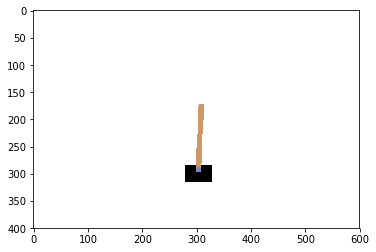

In [2]:
#spawn game instance for tests
env = gym.make("CartPole-v0") #create raw env

observation_shape = env.observation_space.shape
n_actions = env.action_space.n

print("Observation shape: {}".format(observation_shape))
print("Number of actions: {}".format(n_actions))

print("Example state: {}".format(env.reset()))
plt.imshow(env.render('rgb_array'))

# Build DQN Agent

## Define QNetwork

In [23]:
class QNetwork:
    
    def __init__(self, input_shape, n_actions, alpha=0.0003):
        self.input_shape = input_shape
        self.output_shape = n_actions
        self.alpha = alpha
        self.model = self._build_network()

    def _build_network(self):
        model = models.Sequential()
        model.add(layers.InputLayer(self.input_shape))
        model.add(layers.Dense(64, activation='relu'))
        model.add(layers.Dense(self.output_shape, activation='linear'))
        opt = optimizers.RMSprop(lr=self.alpha)
        model.compile(loss='mse', optimizer=opt)
        return model
    
    def predict(self, state):
        """Make prediction for single state and return q values for all actions"""
        s = np.expand_dims(state, axis=0)
        return self.model.predict(s)[0]
    
    def predict_batch(self, states):
        """Make prediction for list of states"""
        return self.model.predict(states)
    
    def train(self, x, y):
        self.model.fit(x, y, batch_size=64, verbose=0)

        
network = QNetwork(observation_shape, n_actions)
network.predict(env.reset())

array([ 0.00021796,  0.00107665], dtype=float32)

## Build traing set

In [24]:
def build_training_set(qvalues, qvalues_next, actions, rewards, dones, gamma=0.99):
    """
    Create training set for QNetwork.
    Params:
      qvalues           - Q values for the starting state
      qvalues_next      - Q values for the state the next state
      actions           - Actions taken
      rewards           - Rewards received after taking action 
      dones             - Did this action end the episode?
      
    Returns:
      Expected qvalues
    """
    y = qvalues.copy()
    next_rewards = np.where(dones, np.zeros(rewards.shape), np.max(qvalues_next, axis=1))
    y[np.arange(y.shape[0]), actions] = rewards + gamma * next_rewards
    return y


# Some tests
qvalues = np.zeros((5, n_actions))
qvalues2 = np.ones((5, n_actions))
actions = np.array([0, 1, 0, 1, 0])
rewards = np.array([1, 2, 3, 4, 5])
dones = np.array([False, False, False, False, True])
expected_y = np.array([[2, 0], [0, 3], [4, 0], [0, 5], [5, 0]])
y = build_training_set(qvalues, qvalues2, actions, rewards, dones, 1.0)
assert np.array_equal(y, expected_y), 'Wrong expected qvalue calculated'
print('Ok!')

Ok!


## Define Agent

In [25]:
class DQNAgent:
    
    def __init__(self, network):
        self.memory_capacity = 100000
        self.epsilon_min = 0.01
        self.epsilon_max = 0.01
        self.epsilon_lambda = 0.001
        self.batch_size = 64
        self.epsilon = self.epsilon_max        
        self.model = network
        self.replays = ReplayBuffer(self.memory_capacity)
        self.step = 0
        
    def policy(self, state):
        if np.random.rand() < self.epsilon:
            action = np.random.randint(0, network.output_shape)
        else:
            qvalues = self.model.predict(state)
            action = np.argmax(qvalues)
            self.step += 1
        self.epsilon = self.epsilon_min + (self.epsilon_max-self.epsilon_min) * np.power(np.e, self.epsilon_lambda*self.step)
        return action
    
    def add_observation(self, state, action, reward, next_state, is_done):
        self.replays.add(state, action, reward, next_state, is_done)
        
    def train(self):
        states, actions, rewards, states_next, dones = self.replays.sample(self.batch_size)
        qvalues = self.model.predict_batch(states)
        qvalues_next = self.model.predict_batch(states_next)
        y = build_training_set(qvalues, qvalues_next, actions, rewards, dones)
        self.model.train(states, y)
    
    
network = QNetwork(observation_shape, n_actions)
agent = DQNAgent(network)
s1 = env.reset()
a = agent.policy(s1)
s2, r, d, _ = env.step(a)
agent.add_observation(s1, a, r, s2, d)
agent.train()
a

1

## Train model

In [26]:
def generate_session(env, agent, t_max=1000):
    
    states,actions = [],[]
    total_reward = 0
    
    state = env.reset()
    
    for t in range(t_max):
        
        # a vector of action probabilities in current state
        action = agent.policy(state)
        next_state, reward, done, info = env.step(action)
        
        #record sessions like you did before
        agent.add_observation(state, action, reward, next_state, done)
        agent.train()
        total_reward += reward
        
        state = next_state
        if done: break
            
    return total_reward


agent = DQNAgent(QNetwork(observation_shape, n_actions))
generate_session(env, agent)

10.0

## Training loops

In [33]:
n_sessions = 2000

agent = DQNAgent(QNetwork(observation_shape, n_actions))

#generate new sessions
rewards = []
for i in range(1, n_sessions+1):
    session_reward = generate_session(env, agent)
    rewards.append(session_reward)
    if i % 100 == 0:
        mean_score = np.mean(rewards[-100:])
        print('Step: {}, reward: {}'.format(i, mean_score))
        if mean_score > 190:
            print("You Won! in {} steps".format(i))
            break
    
plt.plot(rewards)
plt.show()

Step: 100, reward: 8.0
Step: 200, reward: 10.0
Step: 300, reward: 10.0
Step: 400, reward: 8.0
Step: 500, reward: 9.0
Step: 600, reward: 10.0
Step: 700, reward: 19.0
Step: 800, reward: 10.0
Step: 900, reward: 19.0
Step: 1000, reward: 200.0
Step: 1100, reward: 78.0
Step: 1200, reward: 185.0


KeyboardInterrupt: 